# **前日の20:00までの気象予報データを用いて翌日の00:00~23:30までの発電量をMLPで予測する**

### **必要な関数・ライブラリ**

In [2]:
# データ加工・処理・分析モジュール
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import MLP

%matplotlib inline

In [3]:
def set_time(dataframe, col_name):
    '''
    to_datetimeを使うための前処理
    '''
    dataframe[col_name] = dataframe[col_name].map(lambda x : transform_time(x))
    return dataframe

In [4]:
def transform_time(x):
    '''
    set_time内で使う関数
    to_datetimeで24時をサポートしないので00に変更する処理
    '''
    str_x = str(x)
    res = ''
    if str(x)[8:10] == '24':
        res = str_x[0:4] + '-' + str_x[4:6] + '-' + str_x[6:8] + ' 00:'+str_x[10:12] 
    else:
        res = str_x[0:4] + '-' + str_x[4:6] + '-' + str_x[6:8] + ' '+ str_x[8:10] +':'+str_x[10:12]
    return res

In [5]:
def set_datetime(x):
    '''
    指定されたdatetime形式になるように整形
    '''
    str_month = str(x.month)
    if x.month - 10 < 0:
        str_month = "0"+str(x.month)
    str_day = str(x.day)
    if x.day - 10 < 0:
        str_day = "0"+str(x.day)
    str_hour = str(x.hour)
    if x.hour - 10 < 0:
        str_hour = "0"+str(x.hour)
    str_minute = str(x.minute)
    if x.minute == 0:
        str_minute = "00"
    if x.minute == 0 and x.hour == 0:
        str_minute = "00"
        str_hour = "24"
        str_day = str(x.day - 1)
        if (x.day - 1) - 10 < 0:
            str_day = "0"+str(x.day - 1)
                              
    return str(x.year)+str_month+str_day+str_hour+str_minute

In [6]:
def add_hour_month(input_data):
    '''
    時間や月のデータを加える
    '''
    input_data['hour'] = input_data['datetime'].map(lambda x: int(x.hour))
    input_data['minute'] = input_data['datetime'].map(lambda x: int(x.minute))
    input_data['month'] = input_data['datetime'].map(lambda x: int(x.month))
    input_data['month_cos'] = input_data['month'].map(lambda x: np.cos(np.pi * x / 12))
    input_data['month_sin'] = input_data['month'].map(lambda x: np.sin(np.pi * x / 12))
    input_data['hour_cos'] = input_data['hour'].map(lambda x: np.cos(np.pi * x / 24))
    input_data['hour_sin'] = input_data['hour'].map(lambda x: np.sin(np.pi * x / 24))
    input_data = input_data.drop(['hour', 'minute', 'month'], axis=1)
    return input_data

In [7]:
def get_30(tmp_data):
    '''
    必要なカラムだけ拾ってきて30分ごのデータに整形
    '''
    tmp_data = tmp_data[["datetime", "pr", "max_ws", "ave_ws", "max_tp", "min_tp", "sl"]]
    
    # 欠損値を一つ前の値で置換/output_data
    tmp_data = tmp_data.fillna(method='bfill')
    tmp_30 = tmp_data.set_index('datetime').groupby(pd.TimeGrouper(freq='1800s', closed='left')).sum()

    # datetimeのカラムを復活させる
    tmp_30['datetime'] = tmp_30.index
    tmp_30.index = np.arange(len(tmp_30))
    tmp_30.head()
    return tmp_30

In [8]:
def add_time_sincos(input_data):
    '''
    datetimeカラムがあることを前提に月時分の三角関数を足す
    '''
    input_data['hour'] = input_data['datetime'].map(lambda x: int(x.hour))
    input_data['minute'] = input_data['datetime'].map(lambda x: int(x.minute))
    input_data['month'] = input_data['datetime'].map(lambda x: int(x.month))
    input_data['month_cos'] = input_data['month'].map(lambda x: np.cos(np.pi * x / 12))
    input_data['month_sin'] = input_data['month'].map(lambda x: np.sin(np.pi * x / 12))
    input_data['hour_cos'] = input_data['hour'].map(lambda x: np.cos(np.pi * x / 24))
    input_data['hour_sin'] = input_data['hour'].map(lambda x: np.sin(np.pi * x / 24))
    input_data['min_cos'] = input_data['minute'].map(lambda x: np.cos(np.pi * x / 60))
    input_data['min_sin'] = input_data['minute'].map(lambda x: np.sin(np.pi * x / 60))
    return input_data

In [9]:
def normalize_array(x):
    '''
    min, max, min-max正規化を行なった配列(np.array)を返す
    '''
    x = np.array(x)
    x_min = x.min()
    x_max = x.max()
    normalized = (x - x_min) / (x_max - x_min) 
    return x_min, x_max, normalized

In [10]:
def denormalize_array(normalized_x, x_min, x_max):
    '''
    正規化前のmin, maxを用いて元のスケールに戻す
    '''
    normalized_x = np.array(normalized_x)
    denormalize_array = (normalized_x) * (x_max - x_min) + x_min
    return denormalize_array

In [11]:
def drop_nan(X, Y):
    '''
    Yにnanが含まれるペアを削除(他のとこにあるdrop_nanとは別物なので注意)
    '''
    mask = []
    for i in range(len(Y)):
        if np.isnan(Y[i]).sum() == 0:
            mask.append(True)
        else:
            mask.append(False)
    X = X[mask]
    Y = Y[mask]
    return X, Y

In [12]:
def calc_mae(X, Y):
    '''
    X, Yがメモリを食いすぎるのでfor文で計算
    '''
    mse = 0
    for i in range(len(X)):
        mse += np.abs(X[i]- Y[i])
    return mse/len(X)

### **データの準備**

In [13]:
target_place = 2

In [14]:
# 発電量データ
output_30 = pd.read_csv('data/processed_data/out_put.tsv', delimiter = '\t')
output_30['datetime'] = output_30['datetime'].map(lambda x : pd.to_datetime(x))
output_30 = output_30[['datetime', 'SOLA0'+str(target_place)]]

In [15]:
# 天気予報のデータを実は今まで使ってなかった
if target_place == 1 or target_place == 2:
    fc_data = pd.read_csv('data/raw_data/forecast_kanagawa.tsv', delimiter = '\t')
    fc_data['date'] = fc_data['date'].map(lambda x : pd.to_datetime(x))
elif target_place == 3:
    fc_data = pd.read_csv('data/raw_data/forecast_yamanashi.tsv', delimiter = '\t')
    fc_data['date'] = fc_data['date'].map(lambda x : pd.to_datetime(x))
else:
    raise ValueError("invalid input target_place")

In [16]:
# 各降水確率, 各時間帯の天気, 気温のみを選択
fc_data = fc_data.drop(['weather', 'weather_detail', 'wind', 'wave', 'wv_00-03',
       'wv_03-06', 'wv_06-09', 'wv_09-12', 'wv_12-15', 'wv_15-18', 'wv_18-21',
       'wv_21-24', 'wc_00-03', 'wc_03-06', 'wc_06-09', 'wc_09-12', 'wc_12-15',
       'wc_15-18', 'wc_18-21', 'wc_21-24'], axis=1)

In [17]:
hours = ['we_00-03', 'we_03-06', 'we_06-09', 'we_09-12', 'we_12-15', 'we_15-18', 'we_18-21', 'we_21-24']
for hour in hours:
    dummy_df = pd.get_dummies(fc_data[[hour]])
    fc_data = pd.concat([fc_data, dummy_df], axis=1, join='inner')
    fc_data= fc_data.drop([hour], axis=1)

In [19]:
fc_data.head()

,date,pc_00-06,pc_06-12,pc_12-18,pc_18-24,min_tp,max_tp,tp_00-03,tp_03-06,tp_06-09,...,we_15-18_雨,we_15-18_雪,we_18-21_くもり,we_18-21_晴れ,we_18-21_雨,we_18-21_雪,we_21-24_くもり,we_21-24_晴れ,we_21-24_雨,we_21-24_雪
0,2012-01-01,30,30,10,30,3,10,5,4,4,...,0,0,1,0,0,0,0,1,0,0
1,2012-01-02,20,20,10,10,5,11,8,7,6,...,0,0,0,1,0,0,1,0,0,0
2,2012-01-03,0,0,10,10,2,9,4,3,3,...,0,0,1,0,0,0,1,0,0,0
3,2012-01-04,10,10,30,20,2,10,5,4,3,...,0,0,1,0,0,0,1,0,0,0
4,2012-01-05,10,0,0,0,1,8,3,2,1,...,0,0,0,1,0,0,0,1,0,0


In [19]:
# モデル構築のためにデータを分割する

# 学習に必要なデータ
# 前日の気象予報のデータで翌日の0:00 ~ 23:30を予測する
train_x_s_idx = fc_data[fc_data['date'] == pd.to_datetime('2012-01-01')].index[0]
train_x_e_idx = fc_data[fc_data['date'] == pd.to_datetime('2015-12-31')].index[0]
train_y_s_idx = output_30[output_30['datetime'] == pd.to_datetime('2012-01-01 00:00')].index[0]
train_y_e_idx = output_30[output_30['datetime'] == pd.to_datetime('2015-12-31 23:30')].index[0]

output_kwh = output_30["SOLA0"+str(target_place)][train_y_s_idx:train_y_e_idx+1]
input_data = fc_data.drop(["date"], axis=1)[train_x_s_idx:train_x_e_idx+1]

# 予測に必要なデータ
# 前日の00:00 ~ 20:00のデータで翌日の0:00 ~ 23:30を予測する
test_x_s_idx = fc_data[fc_data["date"] == pd.to_datetime('2016-01-01')].index[0]
test_x_e_idx = fc_data[fc_data["date"] == pd.to_datetime('2017-3-31')].index[0]

test_input_data = fc_data.drop(["date"], axis=1)[test_x_s_idx:test_x_e_idx+1]

In [20]:
# MLPに突っ込むための準備をする

# min-max正規化しておく
normalized_input = (input_data - input_data.min()) / (input_data.max() - input_data.min())
normalized_input = np.array(normalized_input)
normalized_kwh = (output_kwh - output_kwh.min()) /( output_kwh.max() - output_kwh.min())
normalized_kwh = np.array(normalized_kwh)

# input_dataに関しては正規化すればそのまま使える
input_list = normalized_input
kwh_list = get_output_data(normalized_kwh)

# outputがnanであれば取り除く
filtered_input_list, filtered_kwh_list = drop_nan(input_list, kwh_list)

# testデータの入力を用意
normalized_test_input = (test_input_data - test_input_data.min()) / (test_input_data.max() - test_input_data.min())
normalized_test_input = np.array(normalized_test_input)

test_input_list = normalized_test_input

# denormalize用
kwh_max = float(output_kwh.max())
kwh_min = float(output_kwh.min())

# MLPに突っ込むためにデータを整形
X = np.array(filtered_input_list).reshape(filtered_input_list.shape[0], filtered_input_list.shape[1])
all_X = np.array(input_list).reshape(input_list.shape[0], input_list.shape[1])
KWH = np.array(filtered_kwh_list).reshape(filtered_kwh_list.shape[0],filtered_kwh_list.shape[1])
X_predict = np.array(test_input_list).reshape(test_input_list.shape[0], test_input_list.shape[1])

In [ ]:
X_train, 

In [1]:
from sklearn import linear_model
linear = linear_model.LinearRegression()

### **モデルの構築**

条件:翌日の気温を予測するには前日の20:00までの気象情報しか使えない

モデル:翌日の気象予報だけのデータで翌日の発電量を予測する

入力:対象日の気象予報のデータ

出力:0:00, 0:30, .... , 23:00, 23:30の気温の配列

In [21]:
epochs = 5000
model_name = "targetplace_"+str(target_place)+"_kwh_fc_one_layer_"+str(epochs)
try:
    os.mkdir('./data/model/'+model_name)
    print("make save directory")
except :
    print("directory already exists")

print(model_name)

make save directory
targetplace_2_kwh_fc_one_layer_5000


In [22]:
mlp_model = MLP.MLP(X, KWH, epochs = epochs, hidden_size = 100, batch_size = 100, model_name = model_name)

In [23]:
mlp_model.train()

train#0, validation loss: 1.236534e-01
train#250, validation loss: 8.719320e-03
train#500, validation loss: 8.673733e-03
train#750, validation loss: 8.502920e-03
train#1000, validation loss: 7.818035e-03
train#1250, validation loss: 7.877336e-03
train#1500, validation loss: 8.329118e-03
train#1750, validation loss: 7.663888e-03
train#2000, validation loss: 7.633363e-03
train#2250, validation loss: 7.261351e-03
train#2500, validation loss: 7.229239e-03
train#2750, validation loss: 7.074979e-03
train#3000, validation loss: 6.835937e-03
train#3250, validation loss: 6.674837e-03
train#3500, validation loss: 6.769986e-03
train#3750, validation loss: 6.380403e-03
train#4000, validation loss: 6.284751e-03
train#4250, validation loss: 6.222855e-03
train#4500, validation loss: 6.108545e-03
train#4750, validation loss: 5.791545e-03


In [24]:
predictions = mlp_model.predict(X)[0]
predictions = predictions.reshape(predictions.shape[0] * predictions.shape[1])
processed_prediction = denormalize_array(predictions, kwh_min, kwh_max)

In [25]:
true = denormalize_array(filtered_kwh_list.reshape(filtered_kwh_list.shape[0] * filtered_kwh_list.shape[1]), kwh_min, kwh_max)

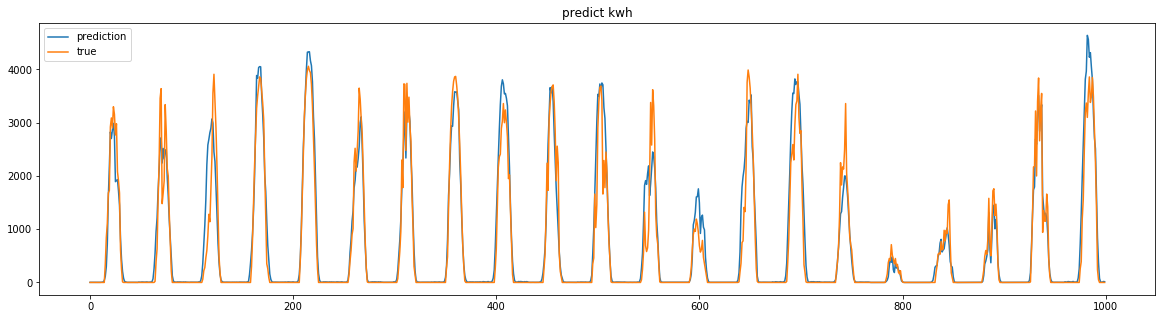

In [26]:
plt.figure(figsize=(20, 5))
plt.plot(processed_prediction[0:1000], label = "prediction")
plt.plot(true[0:1000], label = "true")
plt.legend()
plt.title("predict kwh")

In [27]:
print('training mae :', calc_mae(processed_prediction, true))

training mae : 222.688487775


In [28]:
predictions = mlp_model.predict(all_X)[0]
predictions = predictions.reshape(predictions.shape[0] * predictions.shape[1])
processed_prediction = denormalize_array(predictions, kwh_min, kwh_max)

In [29]:
try:
    predict_data = pd.read_csv('data/predicted_data/predict_train_SOLA0'+str(target_place)+'.tsv', delimiter='\t')
    
except FileNotFoundError:
    s_idx = result[result['datetime'] == pd.to_datetime('2012/01/02 00:00')].index[0]
    e_idx = result[result['datetime'] == pd.to_datetime('2015/12/31 23:30')].index[0]
    predict_data = pd.DataFrame({"datetime":result['datetime'][s_idx:e_idx+1]})
    predict_data.index = np.arange(len(predict_data))
    predict_data.to_csv('data/predicted_data/predict_train_SOLA0'+str(target_place)+'.tsv', sep = '\t', index=False)

In [30]:
# 2012/01/02 00:00 ~ 2015/12/31 23:30の予測データを書き出す
predict_data[model_name] = np.append(processed_prediction[48:-1], processed_prediction[-1])

In [31]:
predict_data.to_csv('data/predicted_data/predict_train_SOLA0'+str(target_place)+'.tsv', sep = '\t', index=False)

In [32]:
validation = mlp_model.predict(mlp_model.X_val)[0]
validation = validation.reshape(validation.shape[0] * validation.shape[1])
processed_validation = denormalize_array(validation, kwh_min, kwh_max)

In [33]:
Y_val = mlp_model.Y_val
Y_val = Y_val.reshape(Y_val.shape[0] * Y_val.shape[1])
Y_val = denormalize_array(Y_val, kwh_min, kwh_max)

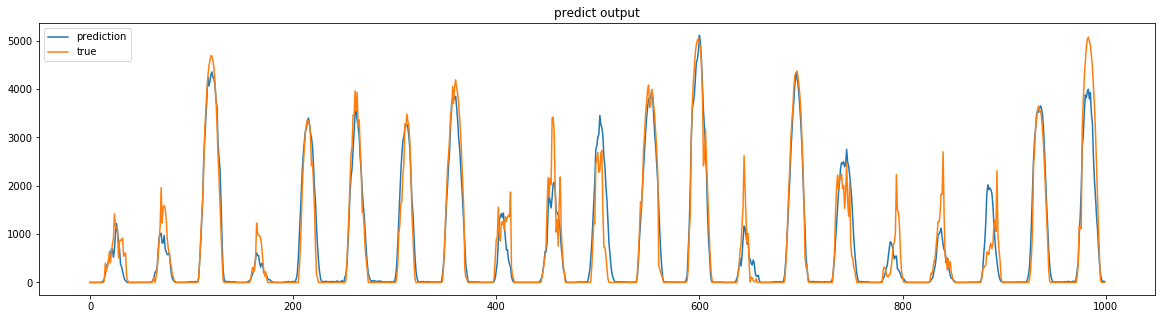

In [34]:
plt.figure(figsize=(20, 5))
plt.plot(processed_validation[0:1000], label = "prediction")
plt.plot(Y_val[0:1000], label = "true")
plt.legend()
plt.title("predict output")

In [35]:
print('validation mae :', calc_mae(processed_validation, Y_val))

validation mae : 234.794309589


In [36]:
# X_predictによる予測
predictions = mlp_model.predict(X_predict)[0]
predictions = predictions.reshape(predictions.shape[0] * predictions.shape[1])
processed_prediction = denormalize_array(predictions, kwh_min, kwh_max)

In [37]:
try:
    predict_data = pd.read_csv('data/predicted_data/predict_SOLA0'+str(target_place)+'.tsv', delimiter='\t')
    
except FileNotFoundError:
    s_idx = result[result['datetime'] == pd.to_datetime('2016/01/01 00:00')].index[0]
    e_idx = result[result['datetime'] == pd.to_datetime('2017/3/31 23:30')].index[0]
    predict_data = pd.DataFrame({"datetime":result['datetime'][s_idx:e_idx+1]})
    predict_data.index = np.arange(len(predict_data))
    predict_data.to_csv('data/predicted_data/predict_SOLA0'+str(target_place)+'.tsv', sep = '\t', index=False)

In [38]:
# 2016/01/01 00:00 ~ 2017/3/31 23:30の予測データを書き出す
predict_data[model_name] = processed_prediction

In [39]:
predict_data.to_csv('data/predicted_data/predict_SOLA0'+str(target_place)+'.tsv', sep = '\t', index=False)